In [1]:
from PIL import Image
import os.path
import numpy as np
import itertools
import keras.backend as K
import keras
from IPython.display import clear_output
import pandas
import time
import tensorflow as tf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [ ]:
def resizeImg(action, x , y):
    avgX = x
    avgY = y
    counter = 0
    filelist= [file for file in os.listdir(action + '/') if file.endswith('.jpeg')]
    for filename in filelist:
    #for filename in itertools.islice(filelist, 0, 100):
        img = Image.open(action + '/' + filename)
        imgResize = img.resize((avgX, avgY), Image.LANCZOS)
        imgResize.save('resized1125x750/' + action + '/' + filename)
        img.close()
        counter +=1
        if (counter % 100) == 0:
            clear_output(wait=True)
            print(counter, end =" ") 
        

In [ ]:
resizeImg('train',1125,750)

In [2]:
def process_image(action, labels_file):
    counter = 0
    labels = pandas.read_csv(labels_file)
    X = []
    y = []

    filelist= [file for file in os.listdir('resized375x250/' + action + '/') if file.endswith('.jpeg')]
    for filename in filelist:
    #for filename in itertools.islice(filelist, 0, 1000):
        #print(filename)
        img = Image.open('resized375x250/' + action + '/' + filename)
        #imgData = list(img.getdata())
        #imgData = np.asarray(imgData)
        #imgData = img.getdata()
        #imgData = np.asarray(imgData)
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        imgData = np.asarray(rgbimg)
        #imgData = np.asarray(img)
        #print(imgData.shape)
        #print(imgData.ndim)
        if imgData.ndim == 3:
            x = imgData.reshape(375,250,3)
            X.append(x)
            #level = labels.loc[labels['image'] == '11909_right.jpeg']
            #print(int(level['level'].values))
            #print(filename)
            #print(filename[:-5])
            #level = labels.loc[labels['image'] == filename[:-5]]#use for train
            level = labels.loc[labels['image'] == filename]#use for trainModified
            #print(level)
            #print(int(level['level'].values))
            y.append(int(level['level'].values))
        img.close()
        counter +=1
        if (counter % 100) == 0:
            clear_output(wait=True)
            print(counter, end =" ") 
    return X, y

In [3]:
start_time = time.time()
X, y = process_image('trainModified', 'trainLabelsModified.csv')
elapsed_time = time.time() - start_time
print(elapsed_time)

122000 1254.0052473545074


In [4]:
X = np.asarray(X)
y = np.asarray(y)
print("shape of X: " + str(X.shape))
print("length of X: " + str(len(X)))
print("shape of y: " + str(y.shape))
print("length of y: " + str(len(y)))
print("value of y: " + str(y[0]))

shape of X: (122053, 375, 250, 3)
length of X: 122053
shape of y: (122053,)
length of y: 122053
value of y: 0


In [5]:
#split X and y into train and test
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

In [6]:
print("shape of X_train: " + str(X_train.shape))
print("shape of y_train: " + str(y_train.shape))
print("shape of X_test: " + str(X_test.shape))
print("shape of y_test: " + str(y_test.shape))

shape of X_train: (97642, 375, 250, 3)
shape of y_train: (97642,)
shape of X_test: (24411, 375, 250, 3)
shape of y_test: (24411,)


In [ ]:
X_train

In [ ]:
# print('Saving X_train')
# np.save('X_train.npy', X_train)
# print('Saving y_train')
# np.save('y_train.npy', y_train)
# print('Saving X_test')
# np.save('X_test.npy', X_test)
# print('Saving y_test')
# np.save('y_test.npy', y_test)

In [ ]:
# X_train = np.load('X_train.npy)
# y_train = np.load('y_train.npy)
# X_test = np.load('X_test.npy)
# y_test = np.load('y_test.npy)

In [7]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [ ]:
#from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
#lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [ ]:
#filepath="tf_weightsv2-0.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [8]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import multi_gpu_model

In [9]:
#use for channels last
#X_train=X_train.reshape(5216,250,250,3)
X_train=X_train.reshape(97642,375,250,3)
X_test=X_test.reshape(24411,375,250,3)
#X_train=X_train.reshape(800,375,250,3)
#X_test=X_test.reshape(200,375,250,3)
K.set_image_data_format('channels_last')

In [10]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
with tf.device('/cpu:0'):
    base_model = InceptionV3(weights=None, include_top=False , input_shape=(375, 250, 3))
#base_model = InceptionV3(weights=None, include_top=False , input_shape=(375, 250, 3))

In [11]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)#new
#x = Dense(128, activation='relu')(x)#new
#x = Dropout(0.5)(x)#new
x = BatchNormalization()(x)
#x = BatchNormalization(axis=3)(x)#use for channels last
#predictions = Dense(2, activation='sigmoid')(x)
predictions = Dense(5, activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss='categorical_crossentropy', 
                       optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
                       metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',
#              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#              #optimizer='Adam',
#              metrics=['accuracy'])

In [ ]:
print(model.summary())

In [21]:
#train 32 on each GPU
batch_size = 64
#batch_epochs = 1
#total_epochs = 10
epochs = 12

In [25]:
# Since the batch size is 64, each GPU will process 32 samples.
history = parallel_model.fit(X_train, y_train, validation_data = (X_test , y_test),
                             epochs=epochs, batch_size=batch_size)
#history = model.fit(X_train, y_train, validation_data = (X_test , y_test),
#                    callbacks=[lr_reduce,checkpoint], epochs=epochs)
#history = model.fit(X_train, y_train, validation_data = (X_test , y_test),
                    #epochs=epochs, batch_size=batch_size)

Train on 97642 samples, validate on 24411 samples
Epoch 1/12
97642/97642 [==============================] - 1407s 14ms/step - loss: 1.5714 - acc: 0.2883 - val_loss: 2.0727 - val_acc: 0.2589
Epoch 2/12
97642/97642 [==============================] - 1396s 14ms/step - loss: 1.5306 - acc: 0.3173 - val_loss: 1.5160 - val_acc: 0.3348
Epoch 3/12
97642/97642 [==============================] - 1396s 14ms/step - loss: 1.4297 - acc: 0.3753 - val_loss: 1.5090 - val_acc: 0.3975
Epoch 4/12
97642/97642 [==============================] - 1397s 14ms/step - loss: 1.2246 - acc: 0.4715 - val_loss: 1.3920 - val_acc: 0.4705
Epoch 5/12
97642/97642 [==============================] - 1397s 14ms/step - loss: 0.9264 - acc: 0.5834 - val_loss: 0.9445 - val_acc: 0.5819
Epoch 6/12
97642/97642 [==============================] - 1398s 14ms/step - loss: 0.7464 - acc: 0.6496 - val_loss: 0.8349 - val_acc: 0.6257
Epoch 7/12
97642/97642 [==============================] - 1397s 14ms/step - loss: 0.6405 - acc: 0.7053 - val_l

In [ ]:
# #epoch_counter = 0
# for epoch_counter in range(total_epochs):
#     if epoch_counter == 0:
#         with open('trainHistory2-0.pickle', 'wb') as file_history:
#             pickle.dump(history_new.history, file_history)
#         print('save model on epoch#' + str(epoch_counter))
#         model.save(diabetic_ret_model.h5)
#     else:
#         with open(r"trainHistory2-0.pickle", "rb") as input_file: history = Pickle.load(input_file)
#         if (history_new['val_acc'][len(history_new['val_acc'])-1]) > (max(history['val_acc'])):
#             print('val_acc improved - save model on epoch#' + str(epoch_counter))
#             model.save(diabetic_ret_model.h5)
#         else:
#             print('va_acc did not improve - do not save model')

In [27]:
import pickle

In [28]:
with open('trainHistoryv2-3.pickle', 'wb') as file_history:
    pickle.dump(history.history, file_history)

In [29]:
model.save('diabetic_ret_v2-3-model.h5')

In [ ]:
print(history.history['val_acc'])

In [ ]:
#from keras.models import load_model
#model = load_model('tf_weightsv1-0.hdf5')

In [ ]:
#model.load_weights("tf_weightsv1-0.hdf5")

In [ ]:
with open(r"trainHistoryv2-3.pickle", "rb") as input_file: history = pickle.load(input_file)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
import matplotlib.pyplot as plt
fig1, ax = plt.subplots()
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
fig2, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [31]:
fig1.savefig('acc_v2-3.png')
fig2.savefig('loss_v2-3.png')

In [32]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
#y_true = y_test

In [ ]:
y_true

In [ ]:
pred

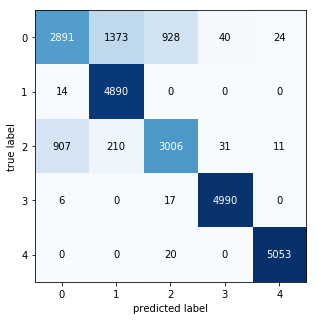

In [33]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(5, 5))
plt.show()

In [34]:
fig.savefig('cm_v2-3.png')

In [ ]:
precision = 390 / (390 + 137)
print(precision)

In [ ]:
recall = 390 / (390 + 0)
print(recall)

In [ ]:
f1 = (2*recall*precision) / (recall + precision)
print(f1)

In [35]:
X_validate, y_validate = process_image('validate', 'validateLabels.csv')

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
X_validate = np.asarray(X_validate)
print("shape of X_validate: " + str(X_validate.shape))

In [ ]:
from keras.models import load_model
model2 = load_model('diabetic_ret_v2-3-model.h5')

In [ ]:
predictions = model2.predict(X_validate)

In [ ]:
predictions

In [ ]:
y_validate